## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
## Analysis

### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df['group'] == 'treatment') != (df['landing_page'] == 'new_page'))].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
i_drop = df[((df['group'] == 'treatment') != (df['landing_page'] == 'new_page'))].index
# drop these non-matching rows
df2 = df.drop(i_drop)

In [9]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(subset=['user_id'], inplace=True)
df2['user_id'].nunique()

290584

In [15]:
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
p_conv = df2['converted'].mean()
p_conv

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_conv_ctr = df2.groupby('group')['converted'].mean()['control']
p_conv_ctr

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_conv_trt = df2.groupby('group')['converted'].mean()['treatment']
p_conv_trt

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
p_new = (df2['landing_page'] == 'new_page').mean()
p_new

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

*Half of the sample received new page (and hence are also in the treatment group) - this gives an equal sample size to the control group.

The calculated conversion rate for the treatment group is lower than that for the control group - so we are tentative to say that the new treatment may actually lead to fewer conversions, but without hypothesis testing, we cannot confirm this with confidence.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**<center>Null Hypothesis $H_{0}$: $p_{old}$ - $p_{new}$ $\geqslant$ 0</div></center>**
**<center>Alternative Hypothesis $H_{a}$: $p_{old}$ - $p_{new}$ $<$ 0<center>**
<i><center>Type I error: $\alpha$ = 0.05<center><i>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new_h0 = p_conv
p_new_h0

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br>

In [21]:
p_old_h0 = p_new_h0
p_old_h0

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = (df2['landing_page'] == 'new_page').sum()
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = (df2['landing_page'] == 'old_page').sum()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(n=1, p=p_new_h0, size=n_new)
new_page_converted

array([0, 0, 1, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(n=1, p=p_old_h0, size=n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
diff_h0 = new_page_converted.mean() - old_page_converted.mean()
diff_h0

-0.001289099432293342

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
# simulate 10000 samples of new and old page viewers, success rate being conversion
new_page_conv = np.random.binomial(n=n_new, p=p_new_h0, size=10000)
old_page_conv = np.random.binomial(n=n_old, p=p_old_h0, size=10000)

# broadcast to an array of size 10000
p_diffs = new_page_conv / n_new - old_page_conv / n_old

p_diffs

array([-0.00021549, -0.00089701, -0.00041498, ...,  0.00024569,
       -0.00190169,  0.00290243])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

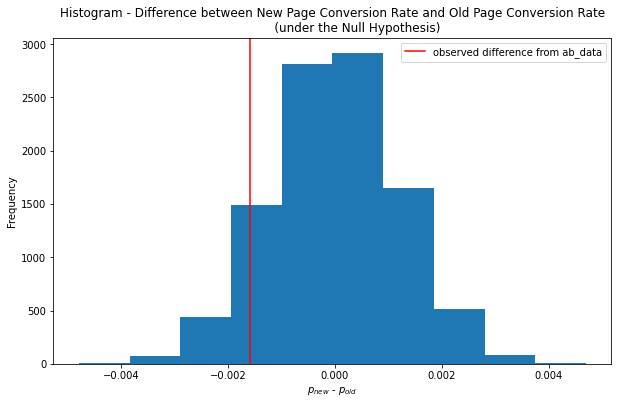

In [28]:
plt.figure(figsize=(10,6))

plt.hist(p_diffs)
plt.axvline(x=p_conv_trt - p_conv_ctr, color='r', label='observed difference from ab_data')

plt.xlabel('$p_{new}$ - $p_{old}$')
plt.ylabel('Frequency')
plt.title('''Histogram - Difference between New Page Conversion Rate and Old Page Conversion Rate
             (under the Null Hypothesis)''')

plt.legend();

In [29]:
p_diffs.mean(), p_diffs.std()

(5.064436913621206e-06, 0.0011963835208315897)

In [30]:
p_diff_obs = p_conv_trt - p_conv_ctr
p_diff_obs / p_diffs.std()  

-1.3191747945997656

The observed is just over one std from the hypothesised mean, and this roughly corresponds to a >68% area in the middle (if two tails), or >84% to the right (if one tail). The alternative hypothesis we had was that $p_{new}$ - $p_{old}$ > 0 and so we would like to see the area to the right of the observed difference.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
(p_diffs > p_diff_obs).mean()

0.9048

Indeed, the area to the right of the observed difference is >84% as evaluated above, and this is also the p-value for our hypothesis testing.

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

*This is the p-value. This measures the area to the right of the observed difference in sample proportions, under the normal distribution assuming the null hypothesis (zero difference) being true. 

Since the result above is high, and is certainly much higher than the selected Type I error of 0.05, there is not enough evidence against the null hypothesis. Therefore, the new page does not make a difference (or worse) to the old page. 

Furthermore, if we were to test that the new page was worse than the old page, i.e., $p_{new}$ - $p_{old}$ < 0 was our alternative hypothesis, then our p-value, i.e., the area to the left of the observed difference is ~0.10, which is also too high to reject the null. Both of these perspectives would suggest that there is in fact no difference in conversion between the new and old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
convert_old = p_conv_ctr
convert_new = p_conv_trt
n_old = n_old
n_new = n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
count = np.array([convert_new * n_new, convert_old * n_old])    # number of successes
nobs = np.array([n_new, n_old])
sm.stats.proportions_ztest(count, nobs, alternative='larger')   # one-sided t-test

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

*Yes they do agree with each other - the p value was 0.9048 with bootstrap or 0.9051 with the statsmodels package. Either way, there is far not enough evidence against the null hypothesis. Therefore, there is no difference in conversion between those receiving the new and those receiving the old pages.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

*Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept'] = 1
df2 = df2.join(pd.get_dummies(df2[['landing_page']]))

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,landing_page_new_page,landing_page_old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [35]:
# remove the old page column and the original landing page column
df2.drop(['landing_page_old_page', 'landing_page'], axis=1, inplace=True)
# rename the new page column
df2.rename(columns={'landing_page_new_page': 'ab_page'}, inplace=True)

df2.head()

,user_id,timestamp,group,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Mar 2021   Pseudo R-squ.:               8.077e-06
Time:                        16:16:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

*The p-value for correlation between received page (new/old) and conversion (yes/no) is 0.190. This value is high and it suggests no correlation between page and conversion, i.e., with a large enough sample, we would expect conversion on old page to be equal to that on new page.

The null hypothesis in this part is that $H_{0}$: $p_{old}$ - $p_{new}$ $=$ 0 (i.e. no correlation) and the alternative hypothesis is $H_{a}$: $p_{old}$ - $p_{new}$ $\neq$ 0 (i.e. conversion is correlated with page). This is essentially a two-tail t-test. In contrast, the hypothesis testing in the previous part is a one-tail t-test. If we designed the latter to be a two-tail t-test as well, the p-value would have been ~0.20, which is quite close to what we have obtained (0.190) in this part.  

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

*Other factors that can be considered are e.g., the time of the day when viewing the page - morning/afternoon/night/other.

We should consider adding this in because it may be associated with a viewer's sentiment and hence correlating to higher/lower inclination to convert. This can also help remove biases in the model and increase our fitness scores for the training set. 

Adding additional terms will make the model more computationally expensive. Also we may encounter the bias (underfit) - variance (overfit) trade-off problem, whereby adding a variable to the model may overfit the regression curve while reducing bias. The result is that we may have low fitness scores for the test dataset. Another aspect is the multicollinearity problem, whereby one variable is dependent on another, and this will result in singularity in matrix inversion.

Anyway, let's see how adding a time variable affects the model.

In [38]:
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2.dtypes

user_id               int64
timestamp    datetime64[ns]
group                object
converted             int64
intercept             int64
ab_page               uint8
dtype: object

In [39]:
df2['timestamp'].min(), df2['timestamp'].max()

(Timestamp('2017-01-02 13:42:05.378582'),
 Timestamp('2017-01-24 13:41:54.460509'))

In [40]:
# create a function to bin the hours data to different times of the day/night
def bin(hr):
    if 5 <= hr < 9:
        return 'early morning'
    elif 9 <= hr < 12:
        return 'morning'
    elif 12 <= hr < 14:
        return 'lunchtime'
    elif 14 <= hr < 18:
        return 'afternoon'
    elif 18 <= hr < 20:
        return 'evening'
    elif 20 <= hr < 23:
        return 'night'
    else:
        return 'midnight'

In [41]:
# bining the hours to time ranges
df2['hour'] = df2['timestamp'].dt.hour
df2['hour_bin'] = df2['hour'].map(lambda x: bin(x))
df2.head()

,user_id,timestamp,group,converted,intercept,ab_page,hour,hour_bin
0,851104,2017-01-21 22:11:48.556739,control,0,1,0,22,night
1,804228,2017-01-12 08:01:45.159739,control,0,1,0,8,early morning
2,661590,2017-01-11 16:55:06.154213,treatment,0,1,1,16,afternoon
3,853541,2017-01-08 18:28:03.143765,treatment,0,1,1,18,evening
4,864975,2017-01-21 01:52:26.210827,control,1,1,0,1,midnight


In [42]:
# convert time ranges to dummy and remove the original columns and the 'midnight' column
df2 = df2.join(pd.get_dummies(df2['hour_bin']))
df2.drop(['hour', 'hour_bin', 'midnight'], axis=1, inplace=True)

df2.head()

,user_id,timestamp,group,converted,intercept,ab_page,afternoon,early morning,evening,lunchtime,morning,night
0,851104,2017-01-21 22:11:48.556739,control,0,1,0,0,0,0,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,0,1,0,0,1,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,0,1,1,1,0,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,0,1,1,0,0,1,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,1,1,0,0,0,0,0,0,0


In [43]:
# intercept, page and time
feat = ['intercept', 'ab_page', 'afternoon', 'early morning', 'evening', 'lunchtime', 'morning', 'night']
# fit a logistic regression
mod = sm.Logit(df2['converted'], df2[feat])
res = mod.fit()

res.summary()

Optimization terminated successfully.
         Current function value: 0.366101
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290576
Method:                           MLE   Df Model:                            7
Date:                Tue, 23 Mar 2021   Pseudo R-squ.:               5.457e-05
Time:                        16:16:09   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1141
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -2.0155      0.013   -156.315      0.000      -2.041      -1.990
ab_page          -0.0150      0.011     -1.310      0.190      -0.037       0.007
afternoon         0.0277      0.018      1.525      0.127      -0.008       0.063
early morning     0.0264      0.018      1.455      0.146      -0.009       0.062
evening           0.0478      0.023      2.098      0.036       0.003       0.092
lunchtime         0.0519      0.023      2.276      0.023       0.007       0.097
morning           0.0479      0.020      2.422      0.015       0.009       0.087
night             0.0262      0.020      1.317      0.188      -0.013       0.065
=================================================================================
"""

It is evident from the p-values that morning (9-12), lunchtime (12-14) and evening (18-20) have a strong corelation with conversion. So we can remove the other times from the model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [44]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [45]:
df_new.head()

,country,timestamp,group,converted,intercept,ab_page,afternoon,early morning,evening,lunchtime,morning,night
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,0,1,0,0,0,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,0,1,1,1,0,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,1,1,1,1,0,0,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,0,1,0,0,0,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,0,1,1,0,0,0,1,0,0


In [46]:
df_new = df_new.join(pd.get_dummies(df_new['country']))
# drop the original country column and the CA column
df_new.drop(['country', 'CA'], axis=1, inplace=True)

df_new.head()

,timestamp,group,converted,intercept,ab_page,afternoon,early morning,evening,lunchtime,morning,night,UK,US
user_id,,,,,,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,0,1,0,0,0,0,0,0,0,1,0
928468,2017-01-23 14:44:16.387854,treatment,0,1,1,1,0,0,0,0,0,0,1
822059,2017-01-16 14:04:14.719771,treatment,1,1,1,1,0,0,0,0,0,1,0
711597,2017-01-22 03:14:24.763511,control,0,1,0,0,0,0,0,0,0,1,0
710616,2017-01-16 13:14:44.000513,treatment,0,1,1,0,0,0,1,0,0,1,0


In [47]:
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 
                                            'evening', 'lunchtime', 'morning']])
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366102
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            6
Date:                Tue, 23 Mar 2021   Pseudo R-squ.:               5.316e-05
Time:                        16:16:10   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.07920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0393      0.027    -75.868      0.000      -2.092      -1.987
ab_page       -0.0150      0.011     -1.309      0.191      -0.037       0.007
UK             0.0506      0.028      1.782      0.075      -0.005       0.106
US             0.0407      0.027      1.515      0.130      -0.012       0.093
evening        0.0303      0.021      1.460      0.144      -0.010       0.071
lunchtime      0.0344      0.021      1.654      0.098      -0.006       0.075
morning        0.0305      0.017      1.750      0.080      -0.004       0.065
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

It seems that none of the variables have a low p-value to ascertain the relationship. Might there be some variance inflation between page, country and time of the day? let's compute the VIF values:

In [48]:
feat = ['ab_page', 'UK', 'US', 'evening', 'lunchtime', 'morning']
X = df_new[feat]

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif

,VIF Factor,features
0,0.002072,ab_page
1,0.000330,UK
2,0.000936,US
3,0.009378,evening
4,0.003723,lunchtime
5,0.004402,morning


So, no inflation at all - it will just be a problem of insufficient correlation then. However, we can also take a look at feature interaction - between page and country. Let's multiply the two and see below.

In [49]:
# create two interaction variables between page and country
df_new['page_UK'] = df_new['ab_page'] * df_new['UK']
df_new['page_US'] = df_new['ab_page'] * df_new['US']

# now fit the logistic regression model
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK' , 'US', 
                                            'page_UK', 'page_US', 'evening', 'lunchtime', 'morning']])
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366098
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290575
Method:                           MLE   Df Model:                            8
Date:                Tue, 23 Mar 2021   Pseudo R-squ.:               6.466e-05
Time:                        16:16:11   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08831
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0134      0.037    -54.972      0.000      -2.085      -1.942
ab_page       -0.0671      0.052     -1.289      0.197      -0.169       0.035
UK             0.0120      0.040      0.301      0.764      -0.066       0.090
US             0.0177      0.038      0.470      0.639      -0.056       0.092
page_UK        0.0778      0.057      1.370      0.171      -0.033       0.189
page_US        0.0465      0.054      0.864      0.388      -0.059       0.152
evening        0.0303      0.021      1.458      0.145      -0.010       0.071
lunchtime      0.0342      0.021      1.646      0.100      -0.007       0.075
morning        0.0306      0.017      1.752      0.080      -0.004       0.065
==============================================================================
"""

hmm...so adding the interaction variables did not help much with improving the correlation fit either. The p-values are still higher than desired.

<a id='conclusions'></a>
## Conclusions

From the hypothesis testing, we have seen that there is not enough evidence (high p-value) to reject the null hypothesis that the new page makes no or worse difference to the old version. This finding was then further supported by attempting to classify conversion against old/new page with logistic regression - the statsmodels summary table indicates that there is not enough evidence (again with a high p-value) to reject the assumption that there is no correlation between page and conversion. 

Further studies, including adding a time and a country variable and an interaction variable between page and country to the classification model, have shown that none of the variables really made any decent correlations with the conversion rate. Note that adding too many variables to the model may increase the chance of multicollinearity and creep up variance (while reducing bias) in the test/unseen data, resulting in an adversely less fit model. Nevertheless, the least to say here is that the new page design did not help with making a difference to viewer conversions, if not made the situation even worse (we would be more tentative to say so given that the p-value for this hypothesis is just under 0.10 - this would lead us to reject the null at a one-tail significance level of 10%).

Therefore, as a minimum improvement, we should work on redesigning the page to make it more appealing to the audience and run the A/B Test again to satisfy ourselves.